In [ ]:
from ultralytics import YOLO
import cv2
model = YOLO("yolov8n.pt") # 원하는 크기 모델 입력(n ~ x)

# 모델을 사용해 이미지 예측
result = model.predict(source = "./frame/A_mermaid_tale/*.png", conf=0.7, stream=True)

In [ ]:
li = []
for i in result:
    li.append(i)

# ①사람이 있는 사진만 person_predict_maid 폴더에 저장

In [ ]:
import os
import shutil

# 폴더 생성
person_predict_folder = "person_predict_maid"
if not os.path.exists(person_predict_folder):
    os.makedirs(person_predict_folder)

person_results=[]
# 결과 처리
for re in li:
    # 각 예측 결과를 반복하여 사람 객체(cls==0)이 있는지 확인
    has_person = any(int(cls) == 0 for cls in re.boxes.cls)

    # 사람 객체가 있는 경우, 해당 이미지를 person_predict 폴더에 복사하여 저장
    if has_person:
        person_results.append(re)
        # 원본 이미지 경로 가져오기
        original_image_path = re.path
        # 파일명만 추출
        file_name = os.path.basename(original_image_path)
        # 새 저장 경로 지정
        new_path = os.path.join(person_predict_folder, file_name)
        # 이미지 복사 및 저장
        shutil.copy(original_image_path, new_path)

In [ ]:
len(person_results)

# ②person_results리스트를 pickle로 저장

In [ ]:
import os
import pickle
import re

results_folder = "result_pickle_maid"

# 폴더 잇는지 없는 지 확인후 폴더 만들어 주기
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


for res in person_results:
    number = re.sub(r'[^0-9]','',res.path)
    file_path = os.path.join(results_folder,f"result_{number[1:]}.pk1")

    with open(file_path,'wb') as f:
        pickle.dump(res,f)

        
print("Results saved successfully.")

# ③라벨링 하기

In [ ]:
import re
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from PIL import Image

## 3-1 train, test, val 폴더 만들기

In [ ]:
def make_folder():
    # img와 label을 저장할 폴더
    img_label = "maid_tale_image_label"

    # img_label에 넣을 train, test, val 폴더
    subfolders = ["train", "test", "val"]

    # train, test, val 폴더 안에 넣을 서브 폴더들
    sub_subfolders = ["images", "labels"]

    # img_label_folder 폴더 만들기
    if not os.path.exists(img_label):
        os.makedirs(img_label)

    # train, test, val 폴더 만들기
    for subfolder in subfolders:
        path = os.path.join(img_label, subfolder)
        if not os.path.exists(path):
            os.makedirs(path)
        for subsub in sub_subfolders:
            sub_path = os.path.join(path, subsub)
            if not os.path.exists(sub_path):
                os.makedirs(sub_path)
            print(sub_path)
        
    return img_label

## 3-2 x1, y1, x2, y2 값을 형식에 맞춰주고 정규화하기

In [ ]:
def convert_to_yolo_format(x1, y1, x2, y2, img_width, img_height): 
    center_x = (x1 + x2) / 2.0 / img_width
    center_y = (y1 + y2) / 2.0 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return center_x, center_y, width, height

## 3-3 라벨값을 txt 파일로 저장

def split_and_savelabel(result, index, path, selected_img, filename):

- input 값
    * loaded_result.boxes[select_object-1] : 
    * select_object
    * img_label
    * selected_ori_img
    * filename


In [ ]:
def split_and_savelabel(result, index, path, selected_img, filename):
    ori_img = selected_img

    x1, y1, x2, y2 = result.xyxy[0]  # 경계 상자 좌표
    
    img_idx = int(re.search(r'\d+', filename).group())

    conf = result.conf[0]  # 정확도 가져오기
    cls = result.cls[0]  # 클래스 이름 가져오기
    label = loaded_result.names[int(cls)]  # 클래스 이름을 숫자로 변환

    print(0, float(x1), float(y1), float(x2), float(y2))

    print("ori_img(split_and_savelabel) : " , type(ori_img))

    # BGR에서 RGB로 변환
    ori_img_rgb = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    numpy_to_PIL = Image.fromarray(ori_img_rgb)  # Numpy array to PIL image
    train_img_path = os.path.join(path, 'train/images', f'{img_idx}.jpg')

    numpy_to_PIL.save(train_img_path, 'JPEG')  # save PIL image

    img_height, img_width = ori_img.shape[:2]

    yolo_bbox = convert_to_yolo_format(x1, y1, x2, y2, img_width, img_height)

    train_label_path = os.path.join(path, 'train/labels', f'{img_idx}.txt')
    
    # 라벨 파일을 YOLO 형식으로 저장
    with open(train_label_path, "a+") as f:
        f.write(f"0 {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n")

In [ ]:
# label의 배경과 글자 크기 설정 메서드
def make_box(result, count, original_img):
    x1, y1, x2, y2 = result.xyxy[0]  # 경계 상자 좌표
    conf = result.conf[0]

    # 경계 상자 그리기
    cv2.rectangle(original_img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    
    # 텍스트 위치 계산 및 조정
    text = f'object : {count}, acc : {conf:.2f}'
    font_scale = 2.0  # 텍스트 크기 조정
    font_thickness = 4  # 텍스트 두께 조정
    text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    text_w, text_h = text_size
    text_x = int(x1)
    text_y = int(y1) - 10
    
    if text_y < text_h:
        text_y = int(y1) + text_h + 10
    
    # 텍스트 배경 그리기
    cv2.rectangle(original_img, (text_x, text_y - text_h), (text_x + text_w, text_y), (255, 0, 0), -1)
    # 텍스트 그리기
    cv2.putText(original_img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)


maid_tale_image_label\train\images
maid_tale_image_label\train\labels
maid_tale_image_label\test\images
maid_tale_image_label\test\labels
maid_tale_image_label\val\images
maid_tale_image_label\val\labels



------------------------------------------------------------------------------
file_path :  result_pickle_maid\result_5359.pk1


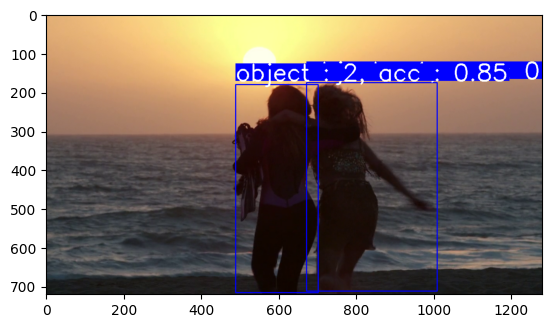




------------------------------------------------------------------------------
file_path :  result_pickle_maid\result_5360.pk1


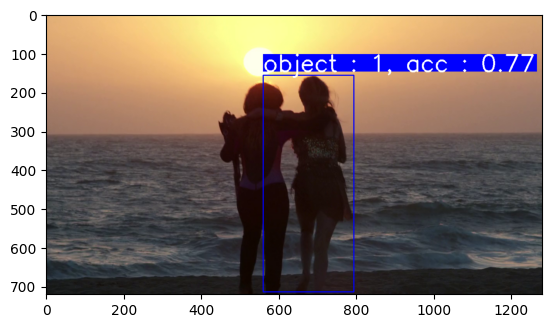




------------------------------------------------------------------------------
file_path :  result_pickle_maid\result_5362.pk1


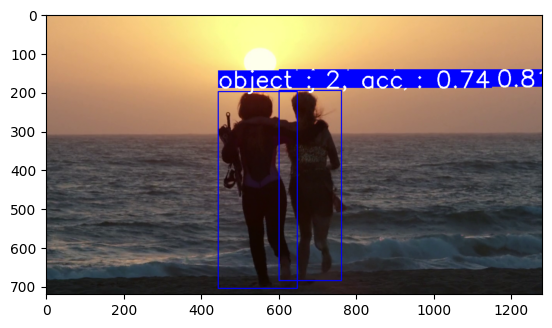




------------------------------------------------------------------------------
file_path :  result_pickle_maid\result_5363.pk1


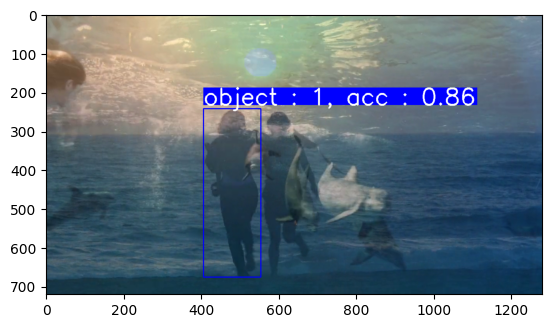

In [12]:
# 폴더 train, test, val 폴더 만들고 path는 img_label에 저장
img_label = make_folder()


# 저장된 pickle 데이터를 가져오기 위해 파일명 가져오기
results_folder = "result_pickle_maid"


# 0, 1, 10, 100 ... 과 같이 정렬되지 않고 0, 1, 2, 3, 4... 순으로 정렬되게 하기 위해서
sorted_result = sorted(os.listdir(results_folder), key=lambda s: int(re.search(r'\d+', s).group()))

# pickle 파일에는 하나의 사진의 정보들이 담겨있다.
# 저장된 모든 Results 객체 불러오기 및 시각화
for filename in sorted_result:
    file_path = os.path.join(results_folder, filename)
    
    # n 번째 사진의 정보
    with open(file_path, 'rb') as f:
        loaded_result = pickle.load(f)
    
    # 사람 객체가 몇개 있는지 확인하기 위해
    count = 0
    original_img = loaded_result.orig_img.copy()  # 원본 이미지 복사(이미지 훼손 때문에)
    print("\n\n")
    print("------------------------------------------------------------------------------")
    print("file_path : ",file_path)
    # 하나의 사진에 여러 라벨값이 저장되어 있어서 하나하나 확인 해주기 위해서
    for box in loaded_result.boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # 경계 상자 좌표
        conf = box.conf[0]
        cls = box.cls[0]
        label = loaded_result.names[int(cls)]

        if label == 'person':
            count += 1
            make_box(box, count, original_img)

    # 그림을 초기화하고 이미지 표시
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.draw()
    plt.pause(0.2)
    plt.show()  # block=True를 추가하여 이미지를 표시하고 멈춤

    select_object = int(input("Select object number (0 to continue): "))
    
    if select_object == 0:
        if os.path.exists(file_path):
            os.remove(file_path)
        continue
    else:

        x1, y1, x2, y2 = loaded_result.boxes[select_object-1].xyxy[0]
        selected_img = loaded_result.orig_img.copy()
        selected_ori_img = loaded_result.orig_img.copy()
        make_box(loaded_result.boxes[select_object-1], select_object, selected_img)
    
        # 이 부분에 dataframe 만들고 split 하기
        split_and_savelabel(loaded_result.boxes[select_object-1], select_object, img_label, selected_ori_img, filename)

        # 그림을 초기화하고 이미지 표시
        plt.imshow(cv2.cvtColor(selected_img, cv2.COLOR_BGR2RGB))
        plt.show(block=True)  # block=True를 추가하여 이미지를 표시하고 멈춤
        print("main_img : ",type(selected_img))
    
        if os.path.exists(file_path):
            os.remove(file_path)


    print("\nselect_object : ",select_object)